In [1]:
import numpy as np
from mpl_toolkits import mplot3d
from rom_am import EDMD, DMD, ROM
import matplotlib.pyplot as plt
import scipy.interpolate as si

In [2]:
pist_pressure = np.load("../DATA/nonlin_Fsi_Results_coeff_1/nln_pist_pressure.npy")
nnt = pist_pressure.shape[0]
moving_mesh = np.load("../DATA/nonlin_Fsi_Results_coeff_1/nln_moving_mesh.npy")
delta_t = np.load("../DATA/nonlin_Fsi_Results_coeff_1/nln_delta_t.npy")
sol_accel = np.load("../DATA/nonlin_Fsi_Results_coeff_1/nln_sol_accel.npy")

t = np.cumsum(delta_t)
nx = moving_mesh.shape[0]
nt = pist_pressure.shape[0]
L = 1
L0 = 1
mass = 1000
rigid = 1e7
Ls0 = 1.2
Lse = Ls0 - 1e5 / rigid

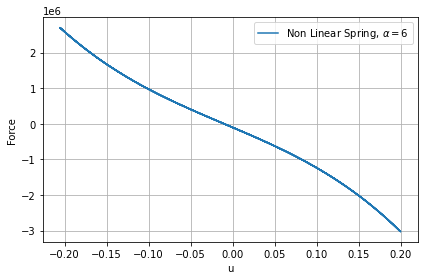

In [3]:
force = mass * sol_accel - pist_pressure
plt.plot(moving_mesh[-1, :] - L0, force, label=r"Non Linear Spring, $\alpha = 6$")
plt.xlabel("u");
plt.ylabel("Force");
plt.grid();
plt.legend();
plt.tight_layout();

In [14]:
# Choose number of equally spaced timesteps 
T = 2.8
n_snap = 280
frac = 2
ntt = int(n_snap /(frac/T))
dt = (t[-1] - t[0]) / (ntt - 1)

# Interpolating original data to the new timesteps
target_t = np.linspace(t[0], t[-1], ntt)
target_pist_pressure = si.griddata(t, pist_pressure.T, target_t, method='linear').T
target_fl_m_mesh = si.griddata(t, moving_mesh.T, target_t, method='linear').T
target_sol_accel = si.griddata(t, sol_accel.T, target_t, method='linear').T

In [17]:
Coeff = 0.7
train_disp = target_fl_m_mesh[-1, :].reshape((1, -1))[:, :int(Coeff*ntt)]-L0
train_pres = target_pist_pressure.reshape((1, -1))[:, :int(Coeff*ntt)]
train_sol_accel = target_sol_accel.reshape((1, -1))[:, :int(Coeff*ntt)]
train_t = t[:int(Coeff*ntt)]

test_disp = target_fl_m_mesh[-1, :].reshape((1, -1))[:, int(Coeff*ntt)::]-L0
test_pres = target_pist_pressure.reshape((1, -1))[:, int(Coeff*ntt)::]
test_sol_accel = target_sol_accel.reshape((1, -1))[:, int(Coeff*ntt)::]
test_t = t[int(Coeff*ntt)::]

X = train_disp[:1, :].reshape((1, -1))
Y = train_disp[:1, :].reshape((1, -1))
observables = {"X" : [lambda x : x, lambda x : x**2, lambda x : x**3, lambda x : np.ones((1, X.shape[1])), lambda x : train_pres],  
               "Y" : [lambda x : train_sol_accel]}

In [18]:
edmd = EDMD()
drom = ROM(edmd)
drom.decompose(X,  Y = Y, dt = dt, observables=observables)

In [19]:
edmd.A

array([[-1.00306895e+04, -3.01795926e+03, -1.00000649e+05,
        -1.00299803e+02,  9.96545995e-04]])

In [ ]:
mass = 1000
rigid = 1e7
mu_coeff = 2
mu = mu_coeff * rigid / 0.2
A = 1
pres_init0 = 1e5
Ls0 = 1.2
L0 = 1
if freq:
    p = lambda t : pres * np.sin(2 * np.pi * freq * t)
else:
    p = lambda t : pres

a_ = rigid;
b_ = mu;
c_ = A * pres_init0;
interm = (((np.sqrt((27 * b_ * c_**2 + 4 * a_**3) / b_)) / (b_ * 2 * 3**(3. / 2.))) - c_ / (2 * b_))**(1. / 3.);
u0 = interm - a_ / (3 * b_ * interm);

a = -rigid/mass - 3*mu*(u0**2)/mass
b = 3*mu*u0/mass
c = -mu/mass
d1 = (u0**3)*mu/mass + rigid * u0/mass 
d2 = A/mass
d = lambda t : d1 + d2 * p(t)
model_param = lambda t : np.array([a, b, c, d(t), d1, d2])
v_dot = lambda u, t : c * u**3 + b * u**2 + a * u + d(t)

ntt = 600
dt = 6e-4
input_t = np.arange(ntt)*dt

from scipy.integrate import solve_ivp
def f(t, y): return np.array([y[1], v_dot(y[0], t)])
sol = solve_ivp(f, [0, input_t[-1]], np.array([(Ls0 - L0), 0]), t_eval = input_t)